In [94]:
GLOBAL_SEED = 1000

In [124]:
ip_display.display(ip_display.HTML("<style>.container { width:100% !important; }</style>"))

In [95]:
from az_common_funcs import *
from preprocessing_utils import preprocessing_utils

In [3]:
import os

In [3]:
df = pd.read_json(f"{data_dir}/S4_sentence_len_matched_labelled_pairs_F1.jsonl", lines=True)

In [4]:
df.head()

,review_id,sent_gte_3,cognitive_score,affective_score,spatial_embedding_score,temporal_embedding_score,narrativity_label,doc_a,review_length,review_num_sentences
0,7778460,True,0.333333,0.333333,2,2,good,Yleen made our week long visit a very enjoyabl...,47,3
1,26416346,True,0.333333,0.333333,2,2,good,Clean and convenient place to stay while we vi...,57,3
2,28564976,True,0.333333,0.333333,2,2,good,I had a wonderful time and was amazed at how m...,62,3
3,32947846,True,0.333333,0.333333,2,2,good,"When I come back to San Antonio, I would 100% ...",53,3
4,38709059,True,0.333333,0.333333,2,2,good,"Great location, only a 10 minute Lyft trip to ...",68,3


In [5]:
df.narrativity_label.value_counts()

narrativity_label
good    12876
bad     12876
Name: count, dtype: int64

In [4]:
pu = preprocessing_utils(ner_categories = 18, ner_library = 'flair', enable_ner = True)

pytorch_model.bin:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

2024-03-27 19:17:20,043 SequenceTagger predicts: Dictionary with 76 tags: <unk>, O, B-CARDINAL, E-CARDINAL, S-PERSON, S-CARDINAL, S-PRODUCT, B-PRODUCT, I-PRODUCT, E-PRODUCT, B-WORK_OF_ART, I-WORK_OF_ART, E-WORK_OF_ART, B-PERSON, E-PERSON, S-GPE, B-DATE, I-DATE, E-DATE, S-ORDINAL, S-LANGUAGE, I-PERSON, S-EVENT, S-DATE, B-QUANTITY, E-QUANTITY, S-TIME, B-TIME, I-TIME, E-TIME, B-GPE, E-GPE, S-ORG, I-GPE, S-NORP, B-FAC, I-FAC, E-FAC, B-NORP, E-NORP, S-PERCENT, B-ORG, E-ORG, B-LANGUAGE, E-LANGUAGE, I-CARDINAL, I-ORG, S-WORK_OF_ART, I-QUANTITY, B-MONEY


In [7]:
df['review_length'] = df['doc_a'].multicore_apply_by_chunks(pu.calculate_word_length, 8, 16)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3212/3212 [00:02<00:00, 1247.05it/s]


In [8]:
df.groupby('narrativity_label')['review_length'].describe()

,count,mean,std,min,25%,50%,75%,max
narrativity_label,,,,,,,,
bad,12876.0,50.700916,44.348114,3.0,19.0,33.0,71.0,461.0
good,12876.0,135.517707,97.241756,20.0,67.0,109.0,172.0,1217.0


In [66]:
df.shape

(25752, 11)

### Process NER

In [6]:
# df['NER_flair_4'] = df['doc_a'].progress_apply(pu.flair_ner)
# df['NER_flair_18'] = df['doc_a'].progress_apply(pu.flair_ner)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [09:32<00:00, 44.98it/s]


In [7]:
# df.to_parquet(f"{temp_dir}/s4_feature_creation_ner_checkpoint.parquet", index=False)

In [5]:
# df = pd.read_parquet(f"{temp_dir}/s4_feature_creation_ner_checkpoint.parquet")
df = pd.read_parquet(f"{temp_dir}/s4_feature_creation_connectives_count_checkpoint.parquet")

In [12]:
ner_list_18 = df['NER_flair_18']
ner_list_4 = df['NER_flair_4']

In [13]:
ner_list_18[0]

[{'text': 'Yleen',
  'start_pos': 0,
  'end_pos': 5,
  'labels': [{'value': 'PERSON', 'confidence': 0.9999947547912598}]},
 {'text': 'week long',
  'start_pos': 15,
  'end_pos': 24,
  'labels': [{'value': 'DATE', 'confidence': 0.9999916553497314}]},
 {'text': 'Lewes',
  'start_pos': 190,
  'end_pos': 195,
  'labels': [{'value': 'GPE', 'confidence': 0.9999874830245972}]},
 {'text': 'Yleen',
  'start_pos': 213,
  'end_pos': 218,
  'labels': [{'value': 'PERSON', 'confidence': 0.999995231628418}]}]

In [20]:
ner_list_4[0]

array([{'end_pos': 5, 'labels': array([{'confidence': 0.9999678134918213, 'value': 'PER'}], dtype=object), 'start_pos': 0, 'text': 'Yleen'},
       {'end_pos': 195, 'labels': array([{'confidence': 0.9999936819076538, 'value': 'LOC'}], dtype=object), 'start_pos': 190, 'text': 'Lewes'},
       {'end_pos': 218, 'labels': array([{'confidence': 0.9999285936355591, 'value': 'PER'}], dtype=object), 'start_pos': 213, 'text': 'Yleen'}],
      dtype=object)

In [5]:
class NERProcessingUtils():
    def extract_unique_loc_ner(self,ner_4_res):
        list_loc = []
        for i in ner_4_res:
            if i['labels'][0]['value'] == 'LOC':
                list_loc.append(i['text'].lower())
        return set(list_loc)
    def extract_unique_per_ner(self,ner_4_res):
        list_per = []
        for i in ner_4_res:
            if i['labels'][0]['value'] == 'PER':
                list_per.append(i['text'].lower())
        return set(list_per)
    def extract_unique_prod_ner(self,ner_18_res):
        list_prod = []
        for i in ner_18_res:
            if i['labels'][0]['value'] == 'PRODUCT':
                list_prod.append(i['text'].lower())
        return set(list_prod)
    def extract_all_where_ner(self,ner_4_res):
        list_loc = []
        for i in ner_4_res:
            if i['labels'][0]['value'] == 'LOC':
                list_loc.append(i['text'].lower())
        return list_loc
    def extract_all_when_ner(self,ner_18_res):
        list_time = []
        for i in ner_18_res:
            if i['labels'][0]['value'] in {'TIME','DATE'}:
                list_time.append(i['text'].lower())
        return list_time

ner_pu = NERProcessingUtils()
# ner_pu.extract_unique_loc_ner(ner_list_4[0]), ner_pu.extract_unique_per_ner(ner_list_4[0]), ner_pu.extract_all_where_ner(ner_list_4[0]), ner_pu.extract_all_when_ner(ner_list_18[0])

In [11]:
df.loc[0, 'doc_a']

'Yleen made our week long visit a very enjoyable one for both my son and I.  She was exceptionally nice and made us feel welcomed in her very nice home.  We look forward to our next visit to Lewes and staying with Yleen again. '

### Process Gold Score Prediction for Sentence Coherence

In [18]:
import pickle

In [19]:
with open("/home/azikre/aadil/github/Transformer-Models-for-Text-Coherence-Assessment/dataset_processor/predictions/predictions_2024_03_20.pkl", mode='rb') as fp:
    gold_score_predictions = pickle.load(fp)

In [43]:
predictions = np.array([i['preds'].numpy() for i in gold_score_predictions])

In [49]:
df["cohesion_score_roberta"] = predictions.reshape(-1, 2).ravel()

In [50]:
df['cohesion_score_roberta'] = df['cohesion_score_roberta'] / 3

In [51]:
# df.to_parquet(f"{temp_dir}/s4_feature_creation_transformer_cohesion_score.parquet", index=False)

### Process Taaco Cohesion

This is implemented in the TAACO Directory in this folder

In [38]:
# cmd(f"cp -r ../github/TAACO ./")

In [4]:
from TAACO.TAACOnoGUI import runTAACO

In [6]:
class TAACO_utils:
    def __init__(self):
        print("init TAACO utils")
        
    def save_df_rows(self,df, id_col, text_col):
        cmd(f"rm {temp_dir}/airbnb_reviews/*.txt")
        for row in df.itertuples():
            with open(f"{temp_dir}/airbnb_reviews/review_{getattr(row, id_col)}.txt", mode = 'w') as fp:
                fp.write(getattr(row, text_col))
                
    def run_TAACO(self, sampleVars=None, save_as="runTaaco_no_name.csv"):
        if not sampleVars: 
            raise NotImplementedError("Pass SampleVars. Default not defined.")
        
        runTAACO(f"{temp_dir}/airbnb_reviews/", f"{temp_dir}/{save_as}", sampleVars)
        print(f"TAACO finished Running. Results saved at: {temp_dir}/{save_as}")

In [6]:
tu = TAACO_utils()

init TAACO utils


In [7]:
# tu.save_df_rows(df, 'review_id', 'doc_a')

In [8]:
# sampleVars = {'sourceKeyOverlap': False,
#  'sourceLSA': False,
#  'sourceLDA': False,
#  'sourceWord2vec': False,
#  'wordsAll': True,
#  'wordsContent': True,
#  'wordsFunction': True,
#  'wordsNoun': True,
#  'wordsPronoun': True,
#  'wordsArgument': True,
#  'wordsVerb': True,
#  'wordsAdjective': True,
#  'wordsAdverb': True,
#  'overlapSentence': True, # Calculate sentence to sentence overlap
#  'overlapParagraph': True,
#  'overlapAdjacent': True, # Calculate overlap for adjacent sections (sentences or paragraphs)
#  'overlapAdjacent2': False,
#  'otherTTR': False,
#  'otherConnectives': True, # Calculate connective indicidence indices
#  'otherGivenness': True, # Calculate givenness indices
#  'overlapLSA': True,
#  'overlapLDA': True,
#  'overlapWord2vec': True,
#  'overlapSynonym': True,
#  'overlapNgrams': True,
#  'outputTagged': False,
#  'outputDiagnostic': False}

# Run TAACO on a folder of texts ("ELLIPSE_Sample/"), give the output file a name ("packageTest.csv), provide output for particular indices/options (as defined in sampleVars)
# tu.run_TAACO(sampleVars)

### Process Count of Adjectives and Count of Adverbs

In [7]:
import spacy

class TextStats:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")

    def __preprocess(self, text):
        # Perform any necessary preprocessing steps
        text = text.lower()
        doc = self.nlp(text)
        return doc

    def count_adjectives(self, text):
        doc = self.__preprocess(text)
        adjectives = [token for token in doc if token.pos_ == "ADJ"]
        return len(adjectives)

    def count_unique_attributes(self, text):
        """
        Assumption : Unique Attributes are Adjectives
        """
        doc = self.__preprocess(text)
        adjectives = [token for token in doc if token.pos_ == "ADJ"]
        return len(set(adjectives))
    
    def count_adverbs(self, text):
        doc = self.__preprocess(text)
        adverbs = [token for token in doc if token.pos_ == "ADV"]
        return len(adverbs)
    
    def count_unique_activites(self, text):
        """
        Assumption : Unique Activities are Adverbs
        """
        doc = self.__preprocess(text)
        adverbs = [token for token in doc if token.pos_ == "ADV"]
        return len(set(adverbs))

In [8]:
ts = TextStats()

In [14]:
df['count_adjectives'] = df['doc_a'].progress_apply(ts.count_adjectives)
df['count_adverbs'] = df['doc_a'].progress_apply(ts.count_adverbs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [03:48<00:00, 112.69it/s]


In [17]:
# df.to_parquet(f"{temp_dir}/s4_feature_creation_adj_adv_count_checkpoint.parquet", index=False)
df.head()

,review_id,sent_gte_3,cognitive_score,affective_score,spatial_embedding_score,temporal_embedding_score,narrativity_label,doc_a,review_length,review_num_sentences,NER,count_adjectives,count_adverbs
0,7778460,True,0.333333,0.333333,2,2,good,Yleen made our week long visit a very enjoyabl...,47,3,"[[Yleen, PERSON], [Lewes, GPE], [Yleen, PERSON]]",4,6
1,26416346,True,0.333333,0.333333,2,2,good,Clean and convenient place to stay while we vi...,57,3,"[[Phoenix, GPE], [an extended weekend, DATE], ...",8,2
2,28564976,True,0.333333,0.333333,2,2,good,I had a wonderful time and was amazed at how m...,62,3,"[[Clarence, PERSON], [El Paso, GPE], [Airbnb, ...",7,2
3,32947846,True,0.333333,0.333333,2,2,good,"When I come back to San Antonio, I would 100% ...",53,3,"[[San Antonio, GPE], [100%, PERCENT], [first, ...",5,6
4,38709059,True,0.333333,0.333333,2,2,good,"Great location, only a 10 minute Lyft trip to ...",68,3,"[[10 minute, TIME], [Lyft, ORG], [Broadway, FA...",5,9


### Process Connectives

In [9]:
import re
class Connectives:
    # TO INDICATE AN EFFECT, RESULT, OR CONSEQUENCE
    list_1 =  ['accordingly', 'consequently', 'henceforth', 'thereupon', 'as a result', 'for this reason', 'in that case', 'thus', 'because', 'forthwith', 'therefore', 'hence']
    
    # TO INDICATE CAUSE, CONDITION, OR PURPOSE 
    list_2 = ['as long as,' 'so long as', 'in order to', 'only if', 'even if', 'to the end that', 'because of', 'in the event that', 'owing to', 'unless', 'due to', 'in the hope that', 'provided that', 'when', 'for fear that', 'in view of', 'seeing that', 'being that', 'whenever', 'for the purpose of', 'inasmuch as', 'since', 'while', 'given that', 'lest', 'so as to', 'with this in mind', 'granted', 'granted that', 'on condition', 'on the condition that', 'so that', 'with this intention']
    
    # TO INDICATE TIME, CHRONOLOGY, OR SEQUENCE 
    list_3 = ['after', 'formerly', 'last', 'sooner', 'later', 'sooner or later', 'all of a sudden', 'forthwith', 'later', 'straightaway', 'as long as', 'from time to time', 'meanwhile', 'suddenly', 'as soon as', 'further', 'next', 'then', 'at the present time', 'at present', 'hence', 'now', 'till', 'at the same time', 'henceforth', 'now that', 'to begin with', 'at this instant', 'immediately', 'occasionally', 'until', 'before', 'in a moment', 'once', 'until now', 'by the time', 'in due time', 'presently', 'up to the present time', 'during', 'in the first place', 'prior to', 'when', 'eventually', 'in the meantime', 'quickly', 'whenever', 'finally', 'in time', 'shortly', 'whenever', 'first', 'second', 'instantly', 'since', 'without delay'] 
    
    # List of Interclausal Connectives 
    # Link : https://mrswarnerarlington.weebly.com/uploads/6/9/0/0/6900648/conjunctions_master_list_alternate_version.pdf
    list_4 = ['And', 'Or', 'But', 'Nor', 'So', 'For', 'Yet' ]
    list_5 = ['After', 'Although', 'As', 'As If', 'As Long As', 'Because', 'Before', 'Even If', 'Even Though', 'If', 'Once', 'Provided', 'Since', 'So That', 'That', 'Though', 'Till', 'Unless', 'Until', 'What', 'When', 'Whenever', 'Wherever', 'Whether', 'While']

    # THESE DO NOT JOIN TWO SENTENCES
    list_6 = ['Accordingly', 'Also', 'Anyway', 'Besides', 'Consequently', 'Finally', 'For Example', 'For Instance', 'Further', 'Furthermore', 'Hence', 'However', 'Incidentally', 'Indeed', 'In Fact', 'Instead', 'Likewise', 'Meanwhile', 'Moreover', 'Namely', 'Now', 'Of Course', 'On the Contrary', 'On the Other Hand', 'Otherwise', 'Nevertheless', 'Next', 'Nonetheless', 'Similarly', 'So Far', 'Until Now', 'Still', 'Then', 'Therefore', 'Thus'] 
    
    list_causal = list_1 + list_2
    list_temporal = list_3
    list_interclausal = list_4 + list_5
    
    def __init__(self, connectives = None):
        
        self.connectives = connectives
        
        if not self.connectives:
            raise ValueError("You must define a type of Connectives to search for. Options are 'interclausal', 'causal' and 'temporal'")
        else:
            if self.connectives == 'interclausal':
                self.connectives_list = Connectives.list_interclausal
            elif self.connectives == 'causal':
                self.connectives_list = Connectives.list_causal
            elif self.connectives == 'temporal':
                self.connectives_list = Connectives.list_temporal
            else:
                raise ValueError("Chosen value of connectives not implemented. Options are 'interclausal', 'causal' and 'temporal'")

        self.pat_to_find = self._generate_pattern()

    def _generate_pattern(self):
        # lowercase
        self.connectives_list = [i for i in self.connectives_list]
        # sort in descending order to account for greedy search 
        self.connectives_list = list(sorted(self.connectives_list, key = lambda x: len(x), reverse = True))
        # join to make the pattern
        _connectives_list = "|".join(self.connectives_list)
        # compile this pattern
        pat = re.compile(_connectives_list)
        # return 
        return pat

    def findall_connectives(self, sentence):
        _found = re.findall(self.pat_to_find, sentence)
        
        # implement : If the word starts the sentence in interclausal connectives, remove from list 
        if self.connectives == 'interclausal':
            return len(_found)
        else:
            return len(_found)

In [58]:
temporal_conn = Connectives('temporal')
causal_conn = Connectives('causal')
interclausal_conn = Connectives('interclausal')

In [59]:
df['count_temporal_connectives'] = df['doc_a'].progress_apply(temporal_conn.findall_connectives)
df['count_causal_connectives'] = df['doc_a'].progress_apply(causal_conn.findall_connectives)
df['count_interclausal_connectives'] = df['doc_a'].progress_apply(interclausal_conn.findall_connectives)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [00:00<00:00, 245413.13it/s]


In [8]:
# df.to_parquet(f"{temp_dir}/s4_feature_creation_connectives_count_checkpoint.parquet", index=False)

### Process NER 5 Subcatefories. Point 4

In [34]:
df['count_unique_attributes'] = df['doc_a'].progress_apply(ts.count_unique_attributes) # Point 4.5
df['count_unique_activites'] = df['doc_a'].progress_apply(ts.count_unique_activites) # Point 4.3

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [03:44<00:00, 114.82it/s]


In [37]:
df['extract_unique_loc_ner'] = df['NER_flair_4'].progress_apply(ner_pu.extract_unique_loc_ner) # Point 4.1
df['extract_unique_per_ner'] = df['NER_flair_4'].progress_apply(ner_pu.extract_unique_per_ner) # Point 4.2

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [00:00<00:00, 608163.81it/s]


In [57]:
df['extract_unique_prod_ner'] = df['NER_flair_18'].progress_apply(ner_pu.extract_unique_prod_ner)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [00:00<00:00, 106237.55it/s]


In [58]:
df['count_unique_locations'] = df['extract_unique_loc_ner'].progress_apply(len)
df['count_unique_persons'] = df['extract_unique_per_ner'].progress_apply(len)
df['count_unique_products'] = df['extract_unique_prod_ner'].progress_apply(len)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [00:00<00:00, 1692894.01it/s]


In [39]:
df['extract_all_where_ner'] = df['NER_flair_4'].progress_apply(ner_pu.extract_all_where_ner) # Point 7
df['extract_all_when_ner'] = df['NER_flair_18'].progress_apply(ner_pu.extract_all_when_ner) # Point 7

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [00:00<00:00, 605670.91it/s]


In [39]:
df['count_all_where_ner'] = df['extract_all_where_ner'].progress_apply(len)
df['count_all_when_ner'] = df['extract_all_when_ner'].progress_apply(len)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [00:00<00:00, 2092763.63it/s]


In [59]:
# df.to_parquet(f"{temp_dir}/s4_feature_creation_ner_counts_checkpoint.parquet", index=False)

### Process Subject Predicate Clauses

In [10]:
df = pd.read_parquet(f"{temp_dir}/s4_feature_creation_ner_counts_checkpoint.parquet")

In [ ]:
import stanza 
stanza.download('en')
nlp = stanza.Pipeline('en', processors = "tokenize,mwt,pos,lemma,depparse", )

In [16]:
# import stanza

# # Download the language model
# stanza.download('en')

# sentence = 'Deemed universities charge huge fees'

# # Build a Neural Pipeline
# nlp = stanza.Pipeline('en', processors = "tokenize,mwt,pos,lemma,depparse", device='cuda:1') 

# # Pass the sentence through the pipeline
# doc = nlp(sentence)

# doc.sentences[0].print_dependencies()
  
# # Convert sentence object to dictionary  
# sent_dict = doc.sentences[0].to_dict()

# # iterate to print the token, relation and head
# for word in sent_dict:
#   print ("{:<15} | {:<10} | {:<15} "
#          .format(str(word['text']),str(word['deprel']), str(sent_dict[word['head']-1]['text'] if word['head'] > 0 else 'ROOT')))

2024-03-27 20:43:33 INFO: Downloading default packages for language: en (English) ...
2024-03-27 20:43:34 INFO: File exists: /home/azikre/stanza_resources/en/default.zip
2024-03-27 20:43:37 INFO: Finished downloading models and saved to /home/azikre/stanza_resources.
2024-03-27 20:43:37 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-03-27 20:43:38 INFO: Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2024-03-27 20:43:38 INFO: Using device: cuda:1
2024-03-27 20:43:38 INFO: Loading: tokenize
2024-03-27 20:43:38 INFO: Loading: mwt
2024-03-27 20:43:38 INFO: Loading: pos
2024-03-27 20:43:38 INFO: Loading: lemma
2024-03-27 20:43:38 INFO: Loading: depparse
2024-03-27 20:43:38 INFO: Done loading processors!


('Deemed', 2, 'amod')
('universities', 3, 'nsubj')
('charge', 0, 'root')
('huge', 5, 'amod')
('fees', 3, 'obj')
Deemed          | amod       | universities    
universities    | nsubj      | charge          
charge          | root       | ROOT            
huge            | amod       | fees            
fees            | obj        | charge          


In [24]:
def count_n_subj(sentence):
    doc = nlp(sentence)
    sent_dict = doc.sentences[0].to_dict()
    ct_n_subj = 0 
    for word in sent_dict:
#         print(word)
        if str(word.get('deprel', 'None')) == 'nsubj':
            ct_n_subj += 1
    return ct_n_subj

In [25]:
df['count_sub_predicates'] = df['doc_a'].progress_apply(count_n_subj)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25752/25752 [34:28<00:00, 12.45it/s]


In [28]:
df['count_sub_predicates'].describe()

count    25752.000000
mean         0.999728
std          1.304619
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max         19.000000
Name: count_sub_predicates, dtype: float64

In [40]:
# df.to_parquet(f"{temp_dir}/s4_feature_creation_subj_predicate_count_checkpoint.parquet", index=False)

### Process Taaco Actually

In [8]:
df_taaco_res = pd.read_csv(f"/home/azikre/aadil/temp/runTaaco_no_name.csv")

In [9]:
df_taaco_res.head()

,Filename,adjacent_overlap_all_sent,adjacent_overlap_all_sent_div_seg,adjacent_overlap_binary_all_sent,adjacent_overlap_2_all_sent,adjacent_overlap_2_all_sent_div_seg,adjacent_overlap_binary_2_all_sent,adjacent_overlap_cw_sent,adjacent_overlap_cw_sent_div_seg,adjacent_overlap_binary_cw_sent,...,negative_logical,all_temporal,positive_intentional,all_positive,all_negative,all_connective,pronoun_density,pronoun_noun_ratio,repeated_content_lemmas,repeated_content_and_pronoun_lemmas
0,review_15199876.txt,0.100000,0.5,0.5,0.166667,1.0,1.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000
1,review_33184162.txt,0.203883,3.5,1.0,0.304348,5.6,1.0,0.107143,1.000000,0.500000,...,0.007353,0.022059,0.007353,0.102941,0.007353,0.088235,0.036765,0.185185,0.117647,0.147059
2,review_2611137.txt,0.100000,2.0,1.0,0.416667,5.0,1.0,0.000000,0.000000,0.000000,...,0.000000,0.033898,0.016949,0.135593,0.000000,0.135593,0.050847,0.300000,0.000000,0.000000
3,review_24537373.txt,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037037,0.074074,0.000000,0.074074,0.037037,0.200000,0.000000,0.000000
4,review_33736176.txt,0.136364,3.0,1.0,0.295455,6.5,1.0,0.030303,0.333333,0.333333,...,0.011494,0.011494,0.011494,0.091954,0.011494,0.103448,0.034483,0.272727,0.022989,0.057471


In [12]:
df_taaco_res ## TODO : Select Features to be a part of the model. 

,Filename,adjacent_overlap_all_sent,adjacent_overlap_all_sent_div_seg,adjacent_overlap_binary_all_sent,adjacent_overlap_2_all_sent,adjacent_overlap_2_all_sent_div_seg,adjacent_overlap_binary_2_all_sent,adjacent_overlap_cw_sent,adjacent_overlap_cw_sent_div_seg,adjacent_overlap_binary_cw_sent,...,negative_logical,all_temporal,positive_intentional,all_positive,all_negative,all_connective,pronoun_density,pronoun_noun_ratio,repeated_content_lemmas,repeated_content_and_pronoun_lemmas
0,review_15199876.txt,0.100000,0.500000,0.500000,0.166667,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000
1,review_33184162.txt,0.203883,3.500000,1.000000,0.304348,5.600000,1.000000,0.107143,1.000000,0.500000,...,0.007353,0.022059,0.007353,0.102941,0.007353,0.088235,0.036765,0.185185,0.117647,0.147059
2,review_2611137.txt,0.100000,2.000000,1.000000,0.416667,5.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.033898,0.016949,0.135593,0.000000,0.135593,0.050847,0.300000,0.000000,0.000000
3,review_24537373.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.037037,0.074074,0.000000,0.074074,0.037037,0.200000,0.000000,0.000000
4,review_33736176.txt,0.136364,3.000000,1.000000,0.295455,6.500000,1.000000,0.030303,0.333333,0.333333,...,0.011494,0.011494,0.011494,0.091954,0.011494,0.103448,0.034483,0.272727,0.022989,0.057471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25748,review_14642036.txt,0.163636,4.500000,1.000000,0.350000,7.000000,1.000000,0.133333,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.269231,0.269231
25749,review_32187078.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,0.100000,0.100000
25750,review_17189701.txt,0.175743,5.916667,0.916667,0.278195,10.090909,1.000000,0.058824,1.166667,0.500000,...,0.007859,0.009823,0.009823,0.082515,0.007859,0.078585,0.068762,0.309735,0.176817,0.245580
25751,review_6586104.txt,0.095506,1.416667,0.583333,0.191358,2.818182,0.909091,0.077922,1.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.405660,0.405660


In [125]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

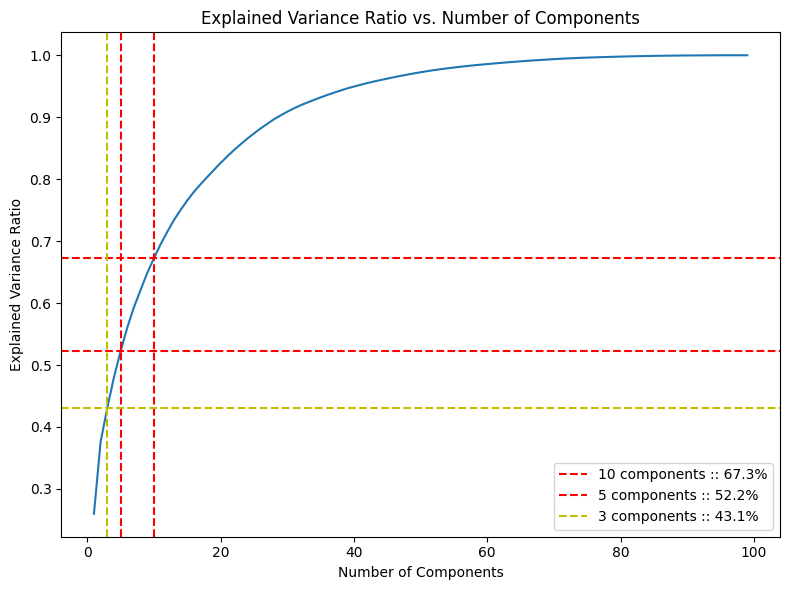

In [126]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_taaco_res.iloc[:,1:])

# Create a PCA object with all components
pca_all = PCA()

# Fit the PCA model to the scaled data
pca_all.fit(X_scaled)

# Get the explained variance ratio for each component
explained_variance_ratio = pca_all.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), linestyle='-')

plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')

n_comp = 10
plt.axvline(x=n_comp, color='r', linestyle='--', label=f'{n_comp} components :: {np.cumsum(explained_variance_ratio)[n_comp-1]:.1%}')
plt.axhline(y=np.cumsum(explained_variance_ratio)[n_comp-1], color='r', linestyle='--')
plt.legend()

n_comp = 5
plt.axvline(x=n_comp, color='r', linestyle='--', label=f'{n_comp} components :: {np.cumsum(explained_variance_ratio)[n_comp-1]:.1%}')
plt.axhline(y=np.cumsum(explained_variance_ratio)[n_comp-1], color='r', linestyle='--')
plt.legend()

n_comp = 3
plt.axvline(x=n_comp, color='y', linestyle='--', label=f'{n_comp} components :: {np.cumsum(explained_variance_ratio)[n_comp-1]:.1%}')
plt.axhline(y=np.cumsum(explained_variance_ratio)[n_comp-1], color='y', linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
# Prompt the user to enter the desired number of components
n_components = 10

# Create a PCA object with the specified number of components
pca = PCA(n_components=n_components)

# Fit the PCA model to the scaled data
pca.fit(X_scaled)

# Get the principal components (eigenvectors)
principal_components = pca.components_

# Transform the data to obtain the transformed PCA vectors
transformed_data = pca.transform(X_scaled)

# Create a new DataFrame with the transformed PCA vectors
pca_df = pd.DataFrame(data=transformed_data, columns=[f'cohesion_pc{i+1}' for i in range(n_components)])

pca_df.insert(0, 'review_id', df_taaco_res['Filename'])

pca_df['review_id'] = pca_df.review_id.apply(lambda x : int(x.split(".")[0].split("_")[1]))

pca_df.head()

,review_id,cohesion_pc1,cohesion_pc2,cohesion_pc3,cohesion_pc4,cohesion_pc5,cohesion_pc6,cohesion_pc7,cohesion_pc8,cohesion_pc9,cohesion_pc10
0,15199876,-4.310053,-4.356760,0.952803,0.147739,-1.107169,3.381279,2.273567,-0.109611,1.225045,-1.102994
1,33184162,5.575841,-0.681813,-1.157820,-1.382770,-0.564278,-0.640651,1.846238,1.227137,0.319313,-0.132136
2,2611137,1.059852,-6.227344,-1.175017,-0.017862,-1.576380,0.102635,-0.110550,0.633885,-0.101055,2.838148
3,24537373,-5.114530,-2.740991,-0.649473,-0.357839,0.455398,-1.268423,0.531677,0.638498,-0.472345,3.922872
4,33736176,6.558503,-2.486169,-3.554791,-2.717477,-2.260326,-1.000547,-3.349500,-0.684292,2.127356,-0.107527


In [103]:
df_taaco_res.columns

Index(['Filename', 'adjacent_overlap_all_sent',
       'adjacent_overlap_all_sent_div_seg', 'adjacent_overlap_binary_all_sent',
       'adjacent_overlap_2_all_sent', 'adjacent_overlap_2_all_sent_div_seg',
       'adjacent_overlap_binary_2_all_sent', 'adjacent_overlap_cw_sent',
       'adjacent_overlap_cw_sent_div_seg', 'adjacent_overlap_binary_cw_sent',
       'adjacent_overlap_2_cw_sent', 'adjacent_overlap_2_cw_sent_div_seg',
       'adjacent_overlap_binary_2_cw_sent', 'adjacent_overlap_fw_sent',
       'adjacent_overlap_fw_sent_div_seg', 'adjacent_overlap_binary_fw_sent',
       'adjacent_overlap_2_fw_sent', 'adjacent_overlap_2_fw_sent_div_seg',
       'adjacent_overlap_binary_2_fw_sent', 'adjacent_overlap_noun_sent',
       'adjacent_overlap_noun_sent_div_seg',
       'adjacent_overlap_binary_noun_sent', 'adjacent_overlap_2_noun_sent',
       'adjacent_overlap_2_noun_sent_div_seg',
       'adjacent_overlap_binary_2_noun_sent', 'adjacent_overlap_verb_sent',
       'adjacent_overlap_v

In [122]:
for pc_vec, comps in enumerate([df_taaco_res.columns[row] for row in np.abs(principal_components).argpartition(-3, 1)[:, -3:] + 1], start=1):
    print(f"{pc_vec} :: {', '.join(comps)}")

1 :: adjacent_overlap_fw_sent_div_seg, adjacent_overlap_2_all_sent_div_seg, adjacent_overlap_all_sent_div_seg
2 :: adjacent_overlap_noun_sent_div_seg, repeated_content_and_pronoun_lemmas, repeated_content_lemmas
3 :: adjacent_overlap_binary_2_adj_sent, adjacent_overlap_adj_sent_div_seg, adjacent_overlap_binary_adj_sent
4 :: lsa_2_all_para, word2vec_2_all_para, word2vec_1_all_para
5 :: adjacent_overlap_2_adv_sent_div_seg, adjacent_overlap_binary_adv_sent, adjacent_overlap_adv_sent_div_seg
6 :: basic_connectives, conjunctions, addition
7 :: adjacent_overlap_verb_sent_div_seg, adjacent_overlap_binary_verb_sent, adjacent_overlap_verb_sent
8 :: adjacent_overlap_pronoun_sent_div_seg, sentence_linking, all_negative
9 :: lsa_2_all_sent, word2vec_1_all_sent, word2vec_2_all_sent
10 :: positive_causal, attended_demonstratives, all_demonstratives


In [123]:
df_taaco_res.columns[np.abs(principal_components).argmax(axis=1) + 1]

Index(['adjacent_overlap_2_all_sent_div_seg', 'repeated_content_lemmas',
       'adjacent_overlap_binary_adj_sent', 'word2vec_1_all_para',
       'adjacent_overlap_adv_sent_div_seg', 'addition',
       'adjacent_overlap_verb_sent', 'all_negative', 'word2vec_2_all_sent',
       'all_demonstratives'],
      dtype='object')

In [35]:
df = pd.read_parquet(f"{temp_dir}/s4_feature_creation_subj_predicate_count_checkpoint.parquet")

In [42]:
df = df.merge(pca_df, on='review_id', how='left', copy=False)

In [44]:
# df.to_parquet(f"{temp_dir}/s4_feature_creation_taaco_checkpoint.parquet", index=False)

### Analyzing NER Output

In [48]:
def get_columns_with_string(df, string):
    column_list = []
    for column in df.columns:
        if string.lower() in column.lower():
            column_list.append(column)
    return column_list
pd.DataFrame.get_columns_with_string = get_columns_with_string

In [52]:
from typing import Union, List
def get_columns_with_strings(df: pd.DataFrame, include_strings: Union[str, List[str]], exclude_strings: Union[str, List[str], None] = None) -> List[str]:

    """
    Returns a list of column names from the input DataFrame that contain any of the specified include strings
    and do not contain any of the specified exclude strings.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame.
    - include_strings (str or list): A single string or a list of strings to search for in the column names.
    - exclude_strings (str or list, optional): A single string or a list of strings to exclude from the column names.
     If not provided, it defaults to None.

    Returns:
    - list: A list of column names that match the specified conditions.
    """
    if isinstance(include_strings, str):
        include_strings = [include_strings]
   
    if isinstance(exclude_strings, str):
        exclude_strings = [exclude_strings]
   
    column_list = []
    for column in df.columns:
        if any(string.lower() in column.lower() for string in include_strings):
            if exclude_strings is None or not any(exclude_string.lower() in column.lower() for exclude_string in exclude_strings):
                column_list.append(column)
    return column_list

pd.DataFrame.get_columns_with_strings = get_columns_with_strings

In [63]:
df.get_columns_with_strings(['ner'], 'count')

['NER',
 'NER_flair_4',
 'NER_flair_18',
 'extract_unique_loc_ner',
 'extract_unique_per_ner',
 'extract_all_where_ner',
 'extract_all_when_ner',
 'extract_unique_prod_ner']

In [88]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_word_cloud(df: pd.DataFrame, column: str) -> None:
    """
    Generates a word cloud from the specified text column of the input DataFrame.

    Parameters:
    - df (pandas.DataFrame): The input DataFrame containing the text data.
    - column (str): The name of the column containing the text data.

    Returns:
    - None
    """
    n_rows = df.shape[0]
    # Check if the specified column contains lists
    if df[column].dtype == 'object' and isinstance(df[column].iloc[0], (list, np.ndarray)):
        # Convert the series of lists to a single list
        text_list = [item for sublist in df[column] for item in sublist]
        print(f'No of rows that have non empty list :: {sum([True if len(sublist) > 0 else False for sublist in df[column]])}')
        print('No of Words Found :: ', len(text_list))
        text = ' '.join(str(item) for item in text_list)
    else:
        # Convert the specified column to string type
        print('No of Words Found :: ', len(df[column]))
        text = ' '.join(df[column].astype(str))
    
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

No of rows that have non empty list :: 10902
No of Words Found ::  18448


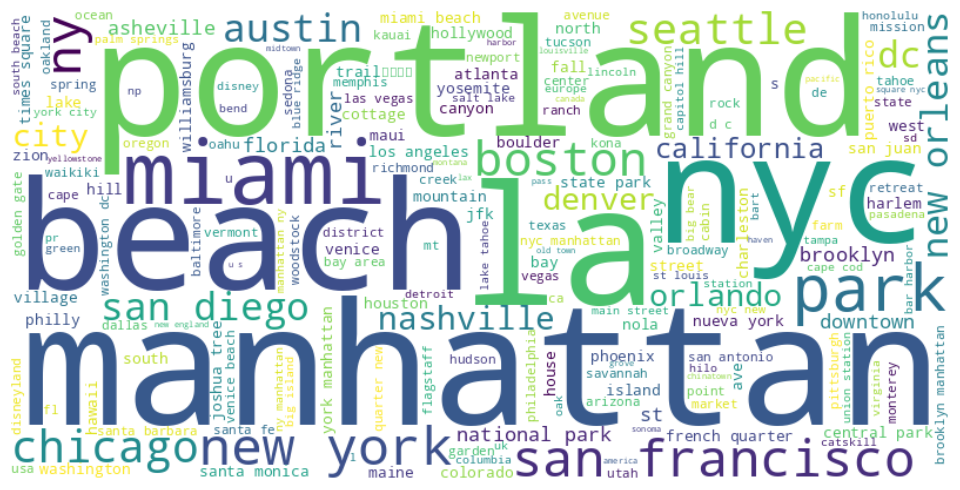

In [89]:
generate_word_cloud(df, 'extract_unique_loc_ner')

No of rows that have non empty list :: 15671
No of Words Found ::  20621


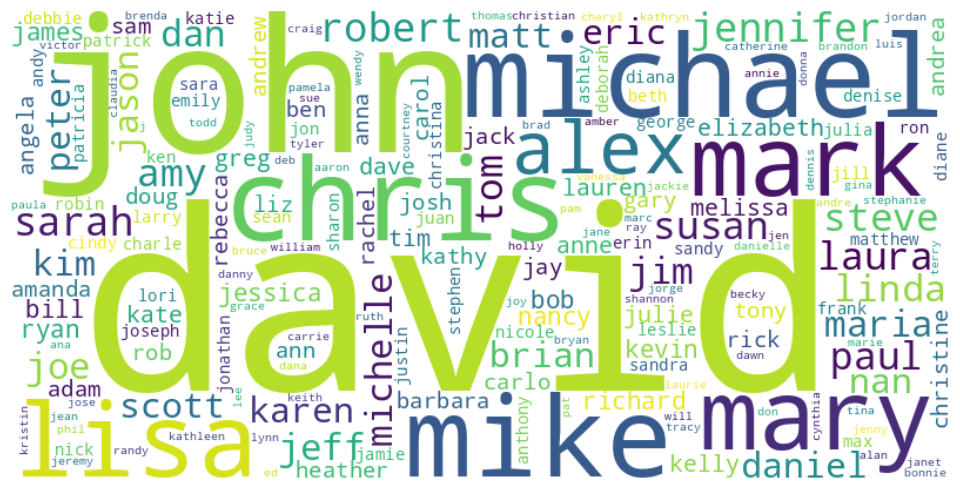

In [90]:
generate_word_cloud(df, 'extract_unique_per_ner')

No of rows that have non empty list :: 10902
No of Words Found ::  21336


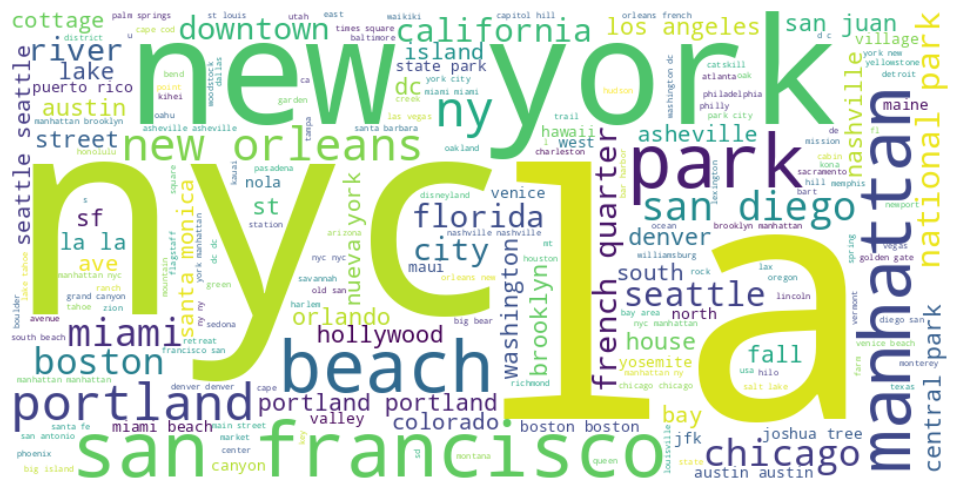

In [91]:
generate_word_cloud(df, 'extract_all_where_ner')

No of rows that have non empty list :: 7533
No of Words Found ::  13914


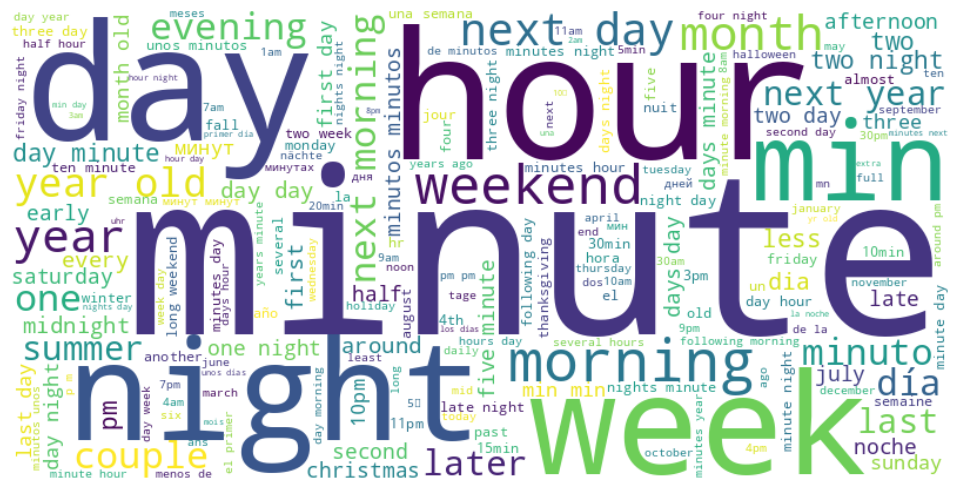

In [92]:
generate_word_cloud(df, 'extract_all_when_ner')

No of rows that have non empty list :: 698
No of Words Found ::  778


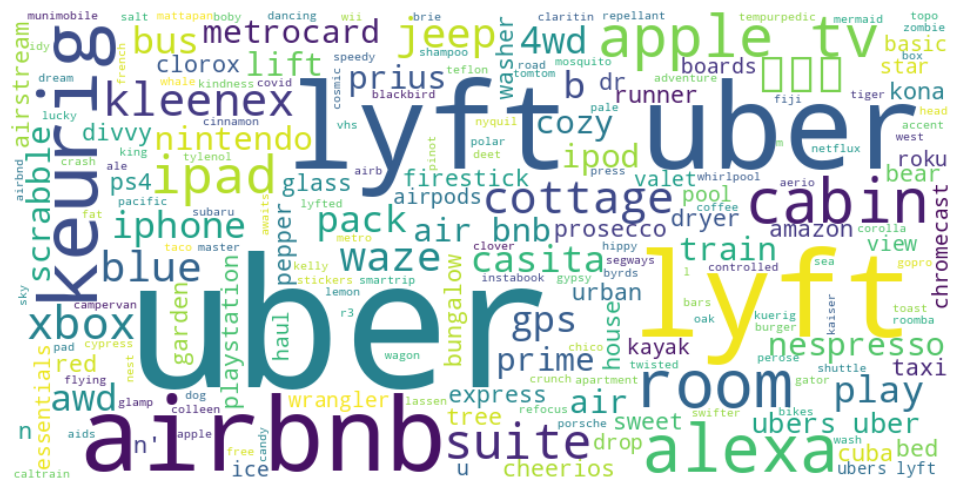

In [93]:
generate_word_cloud(df, "extract_unique_prod_ner")